### Utilização de modelos de Machine Learning para predição de Turnover em uma empresa ###

Este modelo foi criado para o trabalho de conclusão do Curso de Especialização em Ciência de Dados e Big Data da PUC-MG. 

O trabalho consiste em prever a possibilidade de um colaborador sair da empresa ou continuar nela. Um dataset ficticio do repositório Kaggle que possui 14.249 linhas e 10 colunas foi utilizado e enriquecido com uma base criada dinamicamente no python contendo os campos: nome (full_name), gênero (gender) e estado (state / local de nascimento). Neste projeto comparamos 2 algoritmos de classificação:

* KNN (K-Nearest Neighbors)
* SVM (Support Vector Machine)

In [1]:
# Importação das bibliotecas utilizadas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

**Preparação dos dados**

In [2]:
rh = pd.read_csv('datasets/employee_data.csv')
person = pd.read_csv('datasets/random_person.csv')
rh.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [3]:
rh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


In [4]:
# Preenchendo as colunas filed_complaint e recently_promoted com 0 no lugar dos valores ausentes
rh['filed_complaint'].fillna(0, inplace=True)
rh['recently_promoted'].fillna(0,inplace=True)

In [5]:
# Transformando as colunas filed_complaint e recently_promoted em tipos de dados inteiros
rh['filed_complaint'] = rh['filed_complaint'].astype('Int64')
rh['recently_promoted'] = rh['recently_promoted'].astype('Int64')

In [6]:
rh['last_evaluation'].fillna(rh['last_evaluation'].mean(),inplace=True)

In [7]:
# Verificando os valores da coluna department 
rh['department'].unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', nan, 'management',
       'information_technology', 'admin'], dtype=object)

In [8]:
# IT é o mesmo que information_Technology, por isso iremos inserir a mesma info para ambos
rh['department'].replace('information_technology', 'IT', inplace=True)

In [9]:
# Removendo registros com valores ausentes no dataset
rh.dropna(subset=['department', 'tenure'], inplace=True)

In [10]:
rh.reset_index(drop=True, inplace=True)

* Tratamento do segundo dataset

In [11]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14966 entries, 0 to 14965
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_name  14966 non-null  object
 1   gender     14966 non-null  object
 2   state      14966 non-null  object
dtypes: object(3)
memory usage: 350.9+ KB


In [12]:
# Fazendo o join dos datasets rh e person
rh = pd.concat([rh, person], axis=1, join="inner")
rh.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,full_name,gender,state
0,221,engineering,0,0.932868,4,0,low,0.829896,Left,5.0,Robert Ortiz,M,Colorado
1,232,support,0,0.718477,3,0,low,0.834544,Employed,2.0,Ismael Moore,M,Alaska
2,184,sales,0,0.788830,3,0,medium,0.834988,Employed,3.0,Patricia Ford,F,New Jersey
3,206,sales,0,0.575688,4,0,low,0.424764,Employed,2.0,Ward Graham,M,New Jersey
4,249,sales,0,0.845217,3,0,low,0.779043,Employed,3.0,Harry Bellows,M,Virginia


In [13]:
rh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13359 entries, 0 to 13358
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    13359 non-null  int64  
 1   department         13359 non-null  object 
 2   filed_complaint    13359 non-null  Int64  
 3   last_evaluation    13359 non-null  float64
 4   n_projects         13359 non-null  int64  
 5   recently_promoted  13359 non-null  Int64  
 6   salary             13359 non-null  object 
 7   satisfaction       13359 non-null  float64
 8   status             13359 non-null  object 
 9   tenure             13359 non-null  float64
 10  full_name          13359 non-null  object 
 11  gender             13359 non-null  object 
 12  state              13359 non-null  object 
dtypes: Int64(2), float64(3), int64(2), object(6)
memory usage: 1.4+ MB


**Análise dos dados**

In [14]:
rh.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000
mean,201.203159,0.145071,0.718503,3.807845,0.021334,0.622194,3.504155
std,49.930370,0.352185,0.164458,1.235721,0.144500,0.250476,1.473922
min,96.000000,0.000000,0.316175,2.000000,0.000000,0.040058,2.000000
25%,156.000000,0.000000,0.577606,3.000000,0.000000,0.451782,3.000000
50%,200.000000,0.000000,0.718477,4.000000,0.000000,0.654061,3.000000
75%,245.000000,0.000000,0.857885,5.000000,0.000000,0.825668,4.000000
max,310.000000,1.000000,1.000000,7.000000,1.000000,1.000000,10.000000


Text(0, 0.5, '% Percentual')

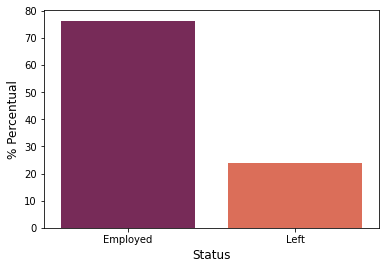

In [15]:
perc = rh['status'].value_counts(normalize=True).mul(100).round(1)
total = rh['status'].value_counts().index

sns.barplot(x=total, y=perc,data=rh, palette='rocket')
plt.xlabel("Status", size=12)
plt.ylabel("% Percentual", size=12)

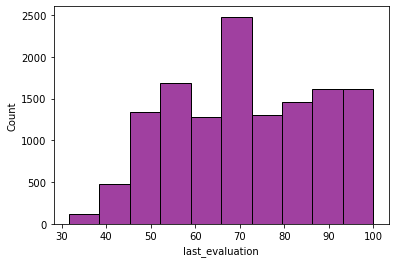

In [16]:
sns.histplot(rh['last_evaluation'].mul(100), kde=False, bins=10, color='purple')

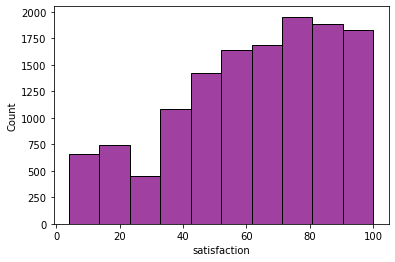

In [17]:
sns.histplot(rh['satisfaction'].mul(100), kde=False, bins=10, color='purple')

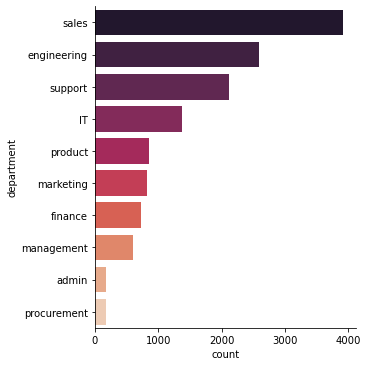

In [18]:
sns.catplot(y="department", kind="count", palette="rocket", data=rh, order= rh['department'].value_counts().index)

In [19]:
group_norm = rh.groupby('recently_promoted')['status'].value_counts(normalize=True)
print(group_norm)

recently_promoted  status  
0                  Employed    0.759599
                   Left        0.240401
1                  Employed    0.936842
                   Left        0.063158
Name: status, dtype: float64


In [20]:
group_norm = rh.groupby('filed_complaint')['status'].value_counts(normalize=True)
print(group_norm)

filed_complaint  status  
0                Employed    0.736100
                 Left        0.263900
1                Employed    0.924149
                 Left        0.075851
Name: status, dtype: float64


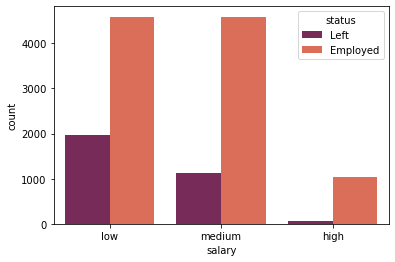

In [21]:
# Salário
sns.countplot(x='salary',data=rh,hue='status', palette='rocket')

In [22]:
# Gênero
rh['gender'].value_counts()

F    6701
M    6658
Name: gender, dtype: int64

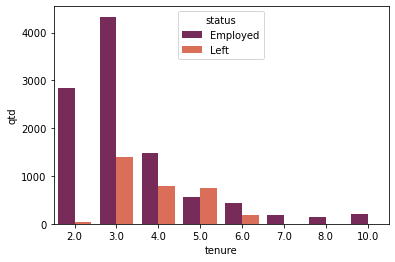

In [23]:
agg_tenure = rh.groupby(['tenure','status']).size()
agg_tenure = agg_tenure.to_frame().reset_index()
agg_tenure = agg_tenure.rename(columns= {0: 'qtd'})

sns.barplot(x='tenure',y='qtd', data=agg_tenure,hue='status', palette='rocket')

### Preparação para treinamento do modelo ###

In [24]:
rh_deploy = rh.iloc[0:1000]
rh_deploy.drop(columns=['full_name','state','status'],inplace=True)
rh_deploy.to_csv('datasets/deploy_turnover_rh.csv', index=False)

rh.drop(columns=['full_name','state'],inplace=True)
rh = rh.iloc[1001:]

c:\users\rapha\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
# Separando a classe das features 
y = rh['status']
X = rh.drop(columns=['status'])

### Encoder ###

In [26]:
le = preprocessing.LabelEncoder()

colunas = ["department","salary","gender"]

df_col=list(colunas)

for i in range(len(df_col)):
    X[df_col[i]] = le.fit_transform(X[df_col[i]])
    
X.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,tenure,gender
1001,130,8,0,0.718477,2,0,1,0.357568,3.0,0
1002,143,2,0,0.506786,2,0,1,0.413923,3.0,1
1003,251,8,0,0.730812,5,0,1,0.796428,2.0,1
1004,142,8,0,0.527755,2,0,1,0.381956,3.0,1
1005,200,8,0,0.716187,3,0,1,0.556537,3.0,0


### Normalizando ###

In [27]:
# Escala os dados
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

### Balanceando as classes ###

**NearMiss**

In [28]:
# Undersampling através de NearMiss
nr = NearMiss()
X, y = nr.fit_resample(X, y)
y.value_counts()

Left        2914
Employed    2914
Name: status, dtype: int64

### Train_test_split ###

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.35, random_state=4) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3788, 10) (2040, 10) (3788,) (2040,)


**Treinando com SVM**

In [30]:
clf = svm.SVC(probability=True).fit(X_train,y_train)
clf

SVC(probability=True)

In [31]:
resultado_svm = clf.predict(X_test)

**Resultados SVM**

In [32]:
acc_svm = "{:.2%}".format(accuracy_score(y_test, resultado_svm))
print("A acurácia do classificador SVM foi de:", acc_svm)

A acurácia do classificador SVM foi de: 90.59%


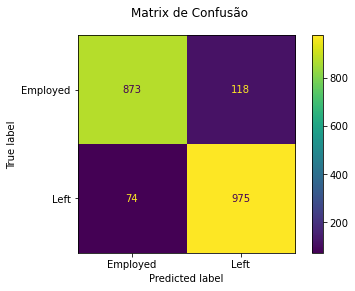

In [33]:
disp = metrics.plot_confusion_matrix(clf,X_test,y_test)
disp.figure_.suptitle('Matrix de Confusão')
plt.show()

In [34]:
print (classification_report(y_test, resultado_svm))

              precision    recall  f1-score   support

    Employed       0.92      0.88      0.90       991
        Left       0.89      0.93      0.91      1049

    accuracy                           0.91      2040
   macro avg       0.91      0.91      0.91      2040
weighted avg       0.91      0.91      0.91      2040



**Utilizando GridSearch para Tunning do SVM**

In [35]:
param_dict = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid_svm = GridSearchCV(clf,
                    param_grid = param_dict,
                    verbose = 3)
grid_svm.fit(X_train,y_train)

resultado_svm_grid = grid_svm.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............................C=1, kernel=linear; total time=   1.1s
[CV 2/5] END .............................C=1, kernel=linear; total time=   1.2s
[CV 3/5] END .............................C=1, kernel=linear; total time=   1.1s
[CV 4/5] END .............................C=1, kernel=linear; total time=   1.1s
[CV 5/5] END .............................C=1, kernel=linear; total time=   1.1s
[CV 1/5] END ................................C=1, kernel=rbf; total time=   0.9s
[CV 2/5] END ................................C=1, kernel=rbf; total time=   0.8s
[CV 3/5] END ................................C=1, kernel=rbf; total time=   0.8s
[CV 4/5] END ................................C=1, kernel=rbf; total time=   0.9s
[CV 5/5] END ................................C=1, kernel=rbf; total time=   1.0s
[CV 1/5] END ............................C=10, kernel=linear; total time=   4.0s
[CV 2/5] END ............................C=10, ke

In [36]:
# O parâmetro C determina a complexidade do modelo, quanto maior mais ridigo o modelo é com relação a erros de classificação.
grid_svm.best_params_

{'C': 10, 'kernel': 'rbf'}

In [37]:
acc_svm_grid = "{:.2%}".format(accuracy_score(y_test, resultado_svm_grid))
print("A acurácia do classificador SVM foi de:", acc_svm_grid)

A acurácia do classificador SVM foi de: 91.96%


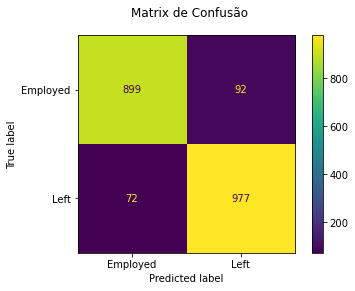

In [38]:
disp = metrics.plot_confusion_matrix(grid_svm,X_test,y_test)
disp.figure_.suptitle('Matrix de Confusão')
plt.show()

In [39]:
print (classification_report(y_test, resultado_svm_grid))

              precision    recall  f1-score   support

    Employed       0.93      0.91      0.92       991
        Left       0.91      0.93      0.92      1049

    accuracy                           0.92      2040
   macro avg       0.92      0.92      0.92      2040
weighted avg       0.92      0.92      0.92      2040



### KNN ###

In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
resultado_knn = knn.predict(X_test)

In [41]:
acc_knn = "{:.2%}".format(accuracy_score(y_test, resultado_knn))
print("A acurácia do classificador KNN foi de:", acc_knn)

A acurácia do classificador KNN foi de: 88.92%


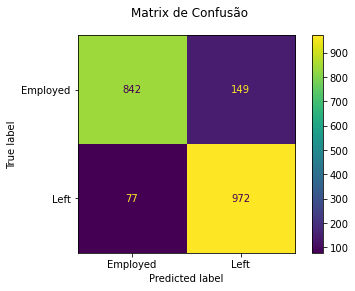

In [42]:
disp = metrics.plot_confusion_matrix(knn,X_test,y_test)
disp.figure_.suptitle('Matrix de Confusão')
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print (classification_report(y_test, resultado_knn))

              precision    recall  f1-score   support

    Employed       0.92      0.85      0.88       991
        Left       0.87      0.93      0.90      1049

    accuracy                           0.89      2040
   macro avg       0.89      0.89      0.89      2040
weighted avg       0.89      0.89      0.89      2040



In [44]:
knn_params = {
'n_neighbors': [3,4,5,6],
'weights': ['uniform','distance'],
'metric':['euclidean','manhattan']
}

grid_knn = GridSearchCV(
	knn,
	knn_params,
	verbose = 3)

grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=4, weights=uniform; total time=   0.0s
[CV 2/5] END metric=euclidean, n

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 4, 5, 6],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [45]:
resultado_knn_grid = grid_knn.predict(X_test)

In [46]:
acc_knn_grid = "{:.2%}".format(accuracy_score(y_test, resultado_knn_grid))
print("A acurácia do classificador KNN foi de:", acc_knn_grid)

A acurácia do classificador KNN foi de: 90.25%


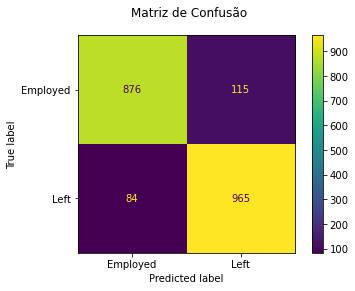

In [47]:
#from sklearn import metrics
disp = metrics.plot_confusion_matrix(grid_knn,X_test,y_test)
disp.figure_.suptitle('Matriz de Confusão')
plt.show()

In [48]:
print (classification_report(y_test, resultado_knn_grid))

              precision    recall  f1-score   support

    Employed       0.91      0.88      0.90       991
        Left       0.89      0.92      0.91      1049

    accuracy                           0.90      2040
   macro avg       0.90      0.90      0.90      2040
weighted avg       0.90      0.90      0.90      2040



### Persistindo o melhor modelo de machine learning ###

In [49]:
pickle.dump(grid_svm, open('grid_svm.sav', 'wb'))